<div style="text-align: right"> <b>[M1 info ML] Réduction de dimensions - 2020/2021</b> </div>
<div style="text-align: right"> <b>TDTP3</b> </div>
<div style="text-align: right"> <a href="mailto:mohamed.maouche@univ-lille.fr"> M. Maouche </a> </div>

### Bibliothéques

In [7]:
import keras
from tqdm.keras import TqdmCallback
from keras.datasets import mnist
from keras import regularizers
from keras import layers
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import backend as K
K.clear_session()

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
mpl.style.use('seaborn')

In [2]:
nb_epochs = 3

### Chargement données

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('1', 'X_train.shape', X_train.shape)
print('1', 'X_test.shape', X_test.shape)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print('2', 'X_train.shape', X_train.shape)
print('2', 'X_test.shape', X_test.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/6, random_state=1)

print('3', 'X_train.shape', X_train.shape)
print('3', 'X_val.shape', X_val.shape)
print('3', 'X_test.shape', X_test.shape)

1 X_train.shape (60000, 28, 28)
1 X_test.shape (10000, 28, 28)
2 X_train.shape (60000, 784)
2 X_test.shape (10000, 784)
3 X_train.shape (50000, 784)
3 X_val.shape (10000, 784)
3 X_test.shape (10000, 784)


- Quelle est la différence entre `X_train`, `X_val` et `X_test` ?

- On entraine sur X_train puis on fait de la cross-val avec X_val pour valider
    - Err(X_val) < Err(X_train)
- X_test est utilisé pour le test

### Premier Auto-encodeur

La fonction suivante permet d'instancier un modèle Feed-Forward auto-encodeurs (FDAE)

In [4]:
def autoencoder_feedforward(input_dim,encoding_dim):
    # This is our input image
    input_layer = keras.Input(shape=(input_dim,))
    
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_layer, decoded)

    # This model maps an input to its encoded representation
    encoder = keras.Model(input_layer, encoded)

    # This is our encoded input
    encoded_input = keras.Input(shape=(encoding_dim,))
    # Retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder, decoder

1- A l'aide de la fonction précédente, générez un modèle FDAE adapté aux données X_train avec comme dimension du code `128`

In [5]:
input_dim = 784
encoding_dim = 128
autoencoder, encoder, decoder = autoencoder_feedforward(input_dim, encoding_dim)

2- Affichez la structure du modèle à l'aide de `<ae>.summary()`

In [6]:
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
Total params: 100,480
Trainable params

3- Lancez l'entrainement du modèle à l'aide du code suivant, en remplaçant `<x>` et `<y>`correctement.

```python
ae.compile(optimizer='adam', loss='mse')
logs = ae.fit(<x>, <y>,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(X_val, X_val))
```

Note : tout le long du TP, faites attention aux temps de calcul. Lancez d'abord avec 2 epochs ou des petites quantités de données pour s'assurer que ça marche. Pour connaitre le nombre d'epochs suffisant regardez si la courbe de loss est stagnante (question suivante).

In [7]:
autoencoder.compile(optimizer='adam', loss='mse')
logs = autoencoder.fit(X_train, X_train,
                epochs=nb_epochs,
                batch_size=64,
                shuffle=True,
                validation_data=(X_val, X_val))

Epoch 1/3
782/782 [==============================] - 11s 14ms/step - loss: 0.0522 - val_loss: 0.0112
Epoch 2/3
782/782 [==============================] - 6s 8ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 3/3
782/782 [==============================] - 11s 14ms/step - loss: 0.0049 - val_loss: 0.0038


4- Dessinez dans une figure la courbe de loss (train et val). Les données sont retrouvables dans ```logs.history```

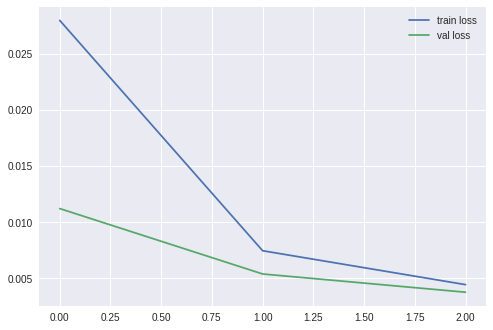

In [8]:
plt.plot(logs.history['loss'], label='train loss')
plt.plot(logs.history['val_loss'], label='val loss')
plt.legend()
plt.show()

5- Extraire de X_test les codes et les données reconstruites correspondantes.

In [9]:
encd = encoder.predict(X_test)
dcd = decoder.predict(encd)

6- Uitlisez les fonctions suivantes pour dessiner dix images du test et leur reconstruction par l'AE

In [10]:
def plot_digits_egs(input_imgs,decoded_imgs,n=10, img_size=0):
    imgSize=int(np.sqrt(input_imgs.shape[1]))
    if img_size != 0:
        imgSize = img_size
    print(imgSize)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(input_imgs[i].reshape(imgSize,imgSize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(imgSize, imgSize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def plot_digits_code(y,encoded_imgs,n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.title(int(y[i]),size=int(32*64/encoded_imgs.shape[1]))
        plt.imshow(encoded_imgs[i].reshape((4, -1)).T)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

28


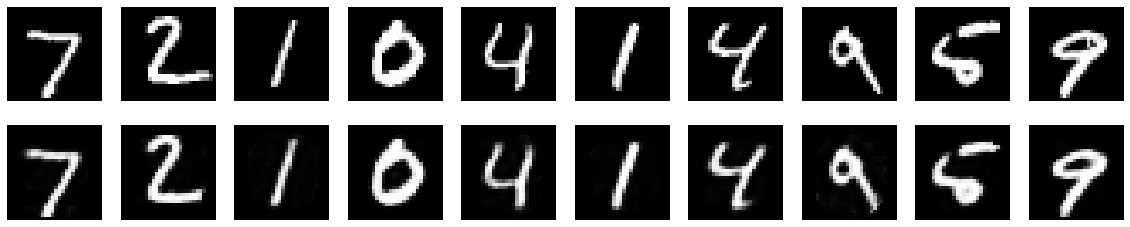

In [11]:
plot_digits_egs(X_test, dcd)

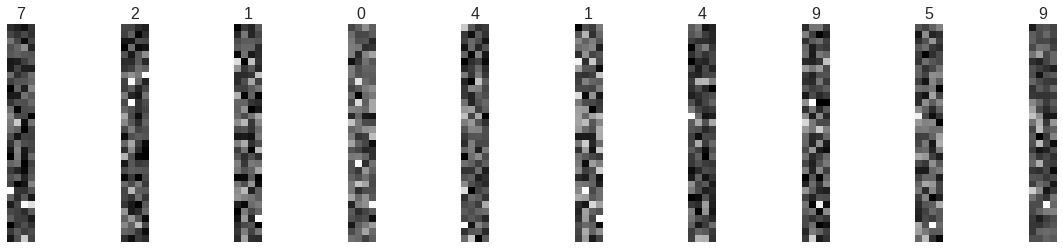

In [12]:
plot_digits_code(y_test, encd)

7- Ecrivez une fonction ```Launch```  effectuant toutes les étapes précédentes du TPs (compilation, entrainement, affichage des loss, affichage des examples). Cette fonction prend en paramètre une description de modèle (e.g.,  `Launch(autoencoder_feedforward,...)`) et d'autres hyperparamètres (e.g., `epochs=20,loss='mse',dim=128`).

In [13]:
def Launch(ae_model, loss, input_dim, encoding_dim, train_datas, val_datas, epochs=nb_epochs, debug=False):
    
    ae, encoder, decoder = ae_model(input_dim, encoding_dim)
    
    if debug:
        print('autoencoder :')
        ae.summary()
        print()
        print('encoder :')
        encoder.summary()
        print()
        print('decoder :')
        decoder.summary()
        print()
    
    ae.compile(optimizer='adam', loss=loss)
    
    if debug:
        print('train_datas[0].shape: ', train_datas[0].shape, ', train_datas[1].shape: ', train_datas[1].shape)
        print('val_datas[0].shape: ', val_datas[0].shape, ', val_datas[1].shape: ', val_datas[1].shape)
        
    logs = ae.fit(train_datas[0], train_datas[1],
                epochs=epochs,
                batch_size=64,
                shuffle=True,
                validation_data=(val_datas[0], val_datas[1]))
    
    # plot loss
    fig, ax = plt.subplots(constrained_layout=True)
    ax.plot(logs.history['loss'], label='train loss')
    ax.plot(logs.history['val_loss'], label='val loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.set_title('Loss Evolution')
    plt.xticks(np.arange(epochs))
    plt.legend()
    plt.show()
    
    return logs, ae, encoder, decoder

autoencoder :
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________

encoder :
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
Total param

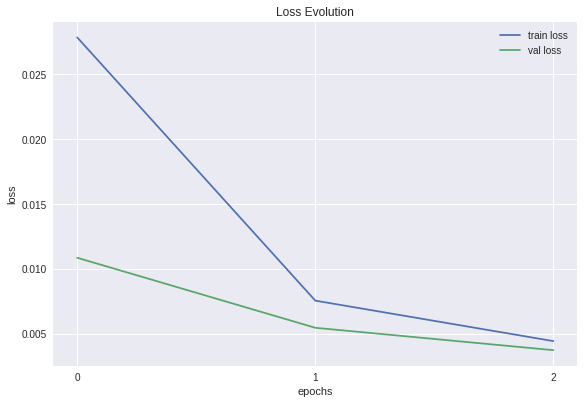

In [14]:
input_dim = 784
encoding_dim = 128
trn_datas = [X_train, X_train]
val_datas = [X_val, X_val]
logs1, ae1, enc1, dec1 = Launch(autoencoder_feedforward, 'mse', input_dim, encoding_dim, 
                                trn_datas, val_datas,
                                debug=True)

28


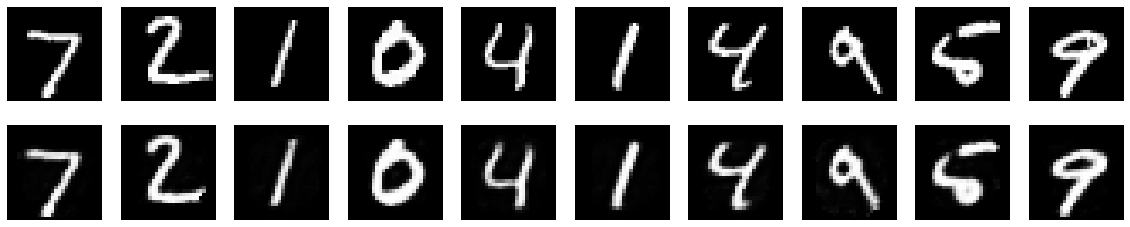

In [15]:
encd_imgs = enc1.predict(X_test)
decd_imgs = dec1.predict(encd_imgs)
plot_digits_egs(X_test, decd_imgs)

### Deep learning

8- Ecrivez la fonction ```autoencoder_deep``` réalisant l'architecture suivante.

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_25 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_51 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_52 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_54 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_55 (Dense)             (None, 784)               101136    
=================================================================
```

In [16]:
def autoencoder_deep(input_dim, encoding_dim):
    # This is our input image
    input_layer = keras.Input(shape=input_dim)
    
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(input_dim, activation='relu')(input_layer)
    encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(encoding_dim, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_layer, decoded)

    # This model maps an input to its encoded representation
    encoder = keras.Model(input_layer, encoded)

    # This is our encoded input
    encoded_input = keras.Input(shape=encoding_dim)
    
    # Retrieve the last layers of the autoencoder model
    decoder_layer = autoencoder.layers[-3](encoded_input)
    decoder_layer = autoencoder.layers[-2](decoder_layer)
    decoder_layer = autoencoder.layers[-1](decoder_layer)
    
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer)
    
    return autoencoder, encoder, decoder

9- Utilisez ```Launch(autoencoder_deep,...)```

autoencoder :
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 784)     

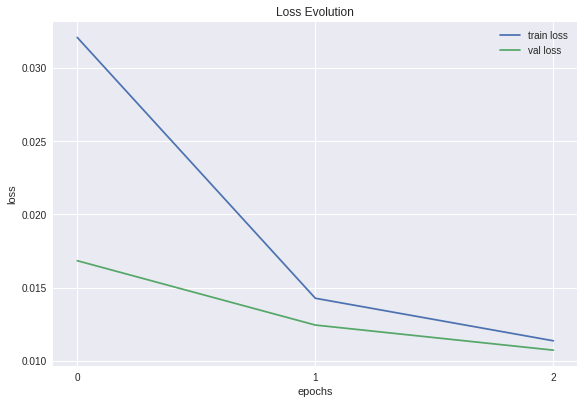

In [17]:
input_dim = 784
encoding_dim = 128
trn_datas = [X_train, X_train]
val_datas = [X_val, X_val]
logs2, ae2, enc2, dec2 = Launch(autoencoder_deep, 'mse', input_dim, encoding_dim, 
                                trn_datas, val_datas, 
                                debug=True)

28


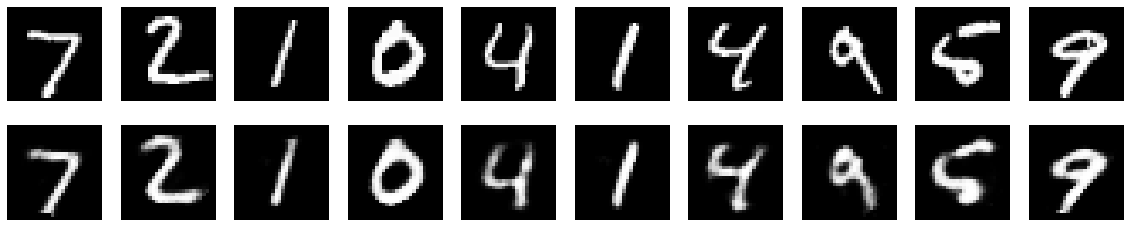

In [18]:
encd_imgs = enc2.predict(X_test)
decd_imgs = dec2.predict(encd_imgs)
plot_digits_egs(X_test, decd_imgs)

### Sparse AE

10- Modifiez ```autoencoder_deep``` pour pouvoir utilisez ou non une régulation sparse de l'AE. Cette régulation est faite à l'aide   

```python
layers.Dense(encoding_dim, activation='sigmoid',activity_regularizer=regularizers.l1(10e-5))(encoded)
```
11- Détectez l'effet de la régulation sur l'AE.

In [19]:
def autoencoder_deep_encoder_reg(input_dim, encoding_dim):
    # This is our input image
    input_layer = keras.Input(shape=(input_dim,))
    
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = layers.Dense(64, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(encoding_dim, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_layer, decoded)

    # This model maps an input to its encoded representation
    encoder = keras.Model(input_layer, encoded)

    # This is our encoded input
    encoded_input = keras.Input(shape=(encoding_dim,))
    
    # Retrieve the last layers of the autoencoder model
    decoder_layer = autoencoder.layers[-3](encoded_input)
    decoder_layer = autoencoder.layers[-2](decoder_layer)
    decoder_layer = autoencoder.layers[-1](decoder_layer)
    
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer)
    
    return autoencoder, encoder, decoder

autoencoder :
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_15 (Dense)             (None, 784)     

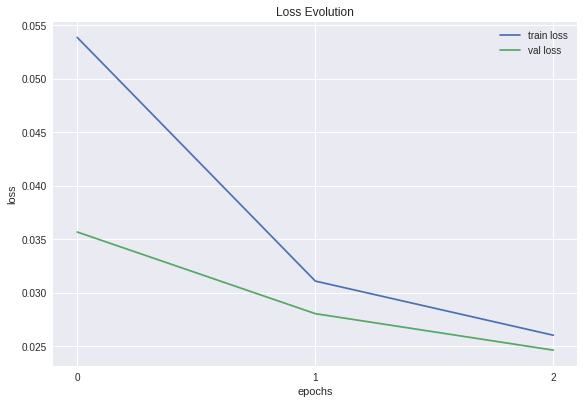

In [20]:
input_dim = 784
encoding_dim = 128
trn_datas = [X_train, X_train]
val_datas = [X_val, X_val]
logs3, ae3, enc3, dec3 = Launch(autoencoder_deep_encoder_reg, 'mse', input_dim, encoding_dim, 
                                trn_datas, val_datas,
                               debug=True)

28


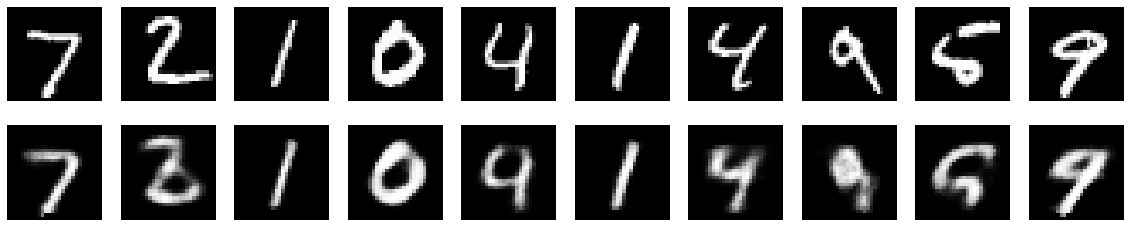

In [21]:
encd_imgs = enc3.predict(X_test)
decd_imgs = dec3.predict(encd_imgs)
plot_digits_egs(X_test, decd_imgs)

In [22]:
def autoencoder_deep_decoder_reg(input_dim, encoding_dim):
    # This is our input image
    input_layer = keras.Input(shape=(input_dim,))
    
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
    encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(64, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
    decoded = layers.Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5))(decoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_layer, decoded)

    # This model maps an input to its encoded representation
    encoder = keras.Model(input_layer, encoded)

    # This is our encoded input
    encoded_input = keras.Input(shape=(encoding_dim,))
    
    # Retrieve the last layers of the autoencoder model
    decoder_layer = autoencoder.layers[-3](encoded_input)
    decoder_layer = autoencoder.layers[-2](decoder_layer)
    decoder_layer = autoencoder.layers[-1](decoder_layer)
    
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer)
    
    return autoencoder, encoder, decoder

autoencoder :
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_21 (Dense)             (None, 784)    

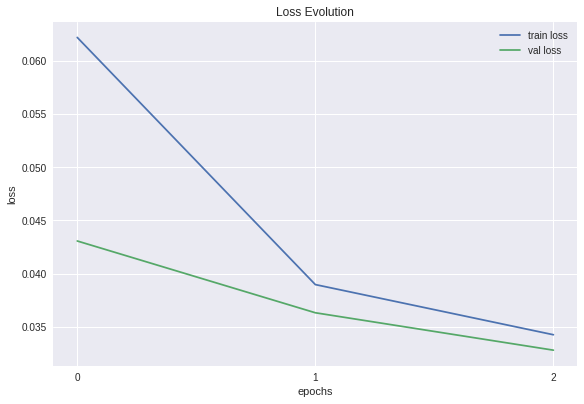

In [23]:
input_dim = 784
encoding_dim = 128
trn_datas = [X_train, X_train]
val_datas = [X_val, X_val]
logs4, ae4, enc4, dec4 = Launch(autoencoder_deep_decoder_reg, 'mse', input_dim, encoding_dim, 
                                trn_datas, val_datas,
                                debug=True)

28


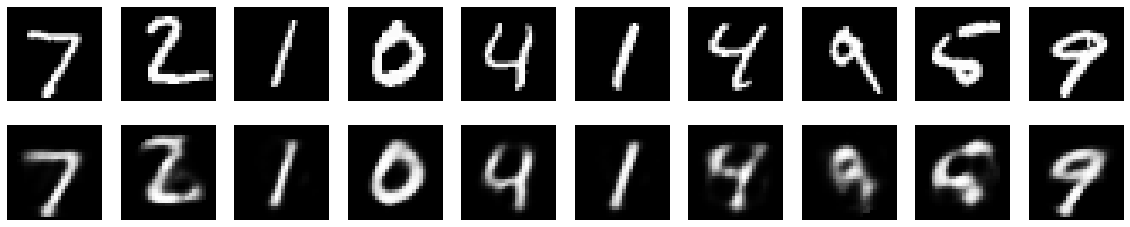

In [24]:
encd_imgs = enc4.predict(X_test)
decd_imgs = dec4.predict(encd_imgs)
plot_digits_egs(X_test, decd_imgs)

In [25]:
def autoencoder_deep_ae_reg(input_dim, encoding_dim):
    # This is our input image
    input_layer = keras.Input(shape=(input_dim,))
    
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = layers.Dense(64, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(64, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
    decoded = layers.Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5))(decoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_layer, decoded)

    # This model maps an input to its encoded representation
    encoder = keras.Model(input_layer, encoded)

    # This is our encoded input
    encoded_input = keras.Input(shape=(encoding_dim,))
    
    # Retrieve the last layers of the autoencoder model
    decoder_layer = autoencoder.layers[-3](encoded_input)
    decoder_layer = autoencoder.layers[-2](decoder_layer)
    decoder_layer = autoencoder.layers[-1](decoder_layer)
    
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer)
    
    return autoencoder, encoder, decoder

autoencoder :
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_27 (Dense)             (None, 784)    

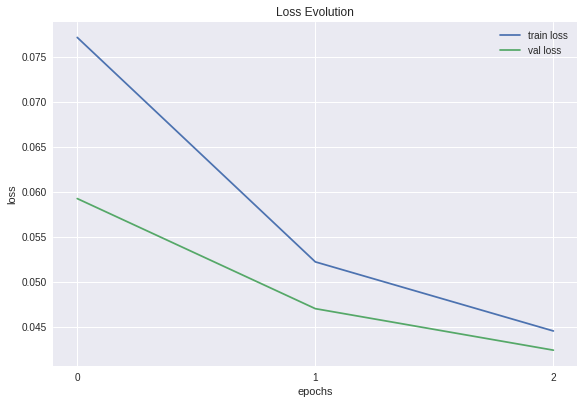

In [26]:
input_dim = 784
encoding_dim = 128
trn_datas = [X_train, X_train]
val_datas = [X_val, X_val]
logs5, ae5, enc5, dec5 = Launch(autoencoder_deep_ae_reg, 'mse', input_dim, encoding_dim, 
                                trn_datas, val_datas,
                                debug=True)

28


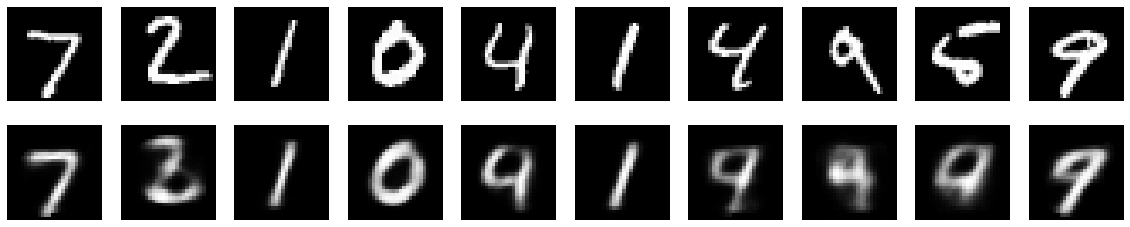

In [27]:
encd_imgs = enc5.predict(X_test)
decd_imgs = dec5.predict(encd_imgs)
plot_digits_egs(X_test, decd_imgs)

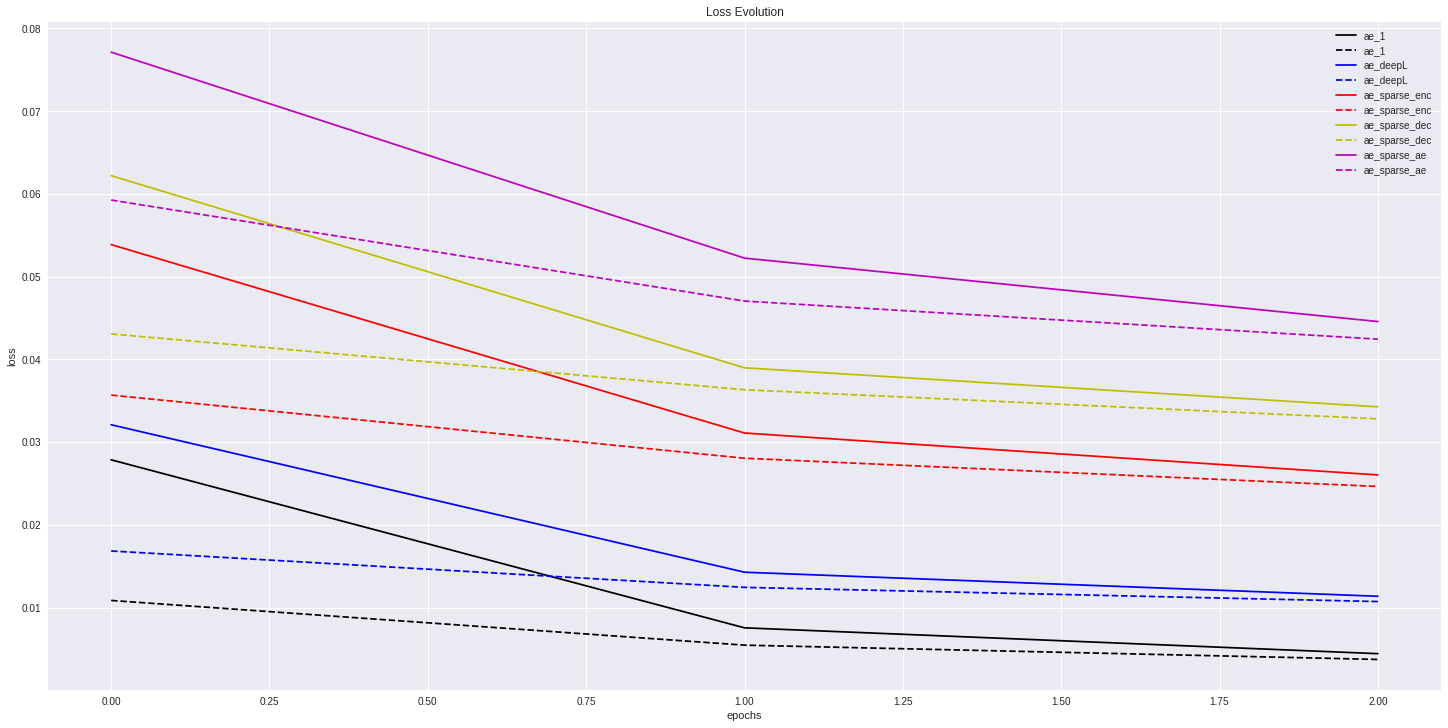

In [28]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(20, 10))
    
ax.plot(logs1.history['loss'], label='ae_1', c='black')
ax.plot(logs1.history['val_loss'], '--', label='ae_1', c='black')
ax.plot(logs2.history['loss'], label='ae_deepL', c='b')
ax.plot(logs2.history['val_loss'], '--', label='ae_deepL', c='b')
ax.plot(logs3.history['loss'], label='ae_sparse_enc', c='r')
ax.plot(logs3.history['val_loss'], '--', label='ae_sparse_enc', c='r')
ax.plot(logs4.history['loss'], label='ae_sparse_dec', c='y')
ax.plot(logs4.history['val_loss'], '--', label='ae_sparse_dec', c='y')
ax.plot(logs5.history['loss'], label='ae_sparse_ae', c='m')
ax.plot(logs5.history['val_loss'], '--', label='ae_sparse_ae', c='m')

ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('Loss Evolution')    
plt.legend()
plt.show()

- On remarque bien que la loss est plus élevé avec la régularisation.
- La loss du AE (encodeur+decodeur) est la plus élevée.
- On remarque que la reg sur le décodeur impacte plus que sur l'encodeur.
    - Loss(dec) > Loss(encd)

### Convolution

12 - Ecrivez la fonction ```autoencoder_conv``` réalisant l'architecture suivante (vous pouvez faire plus réduit ou plus complexe tant qu'il y a de la convolution).

```
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_23 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 1)         145       
=================================================================
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None
```

In [29]:
(X_train_conv, y_train_conv), (X_test_conv, y_test_conv) = mnist.load_data()

X_train_conv = X_train_conv.astype('float32') / 255.
X_test_conv = X_test_conv.astype('float32') / 255.
X_train_conv = np.reshape(X_train_conv, (len(X_train_conv), 28, 28, 1))
X_test_conv = np.reshape(X_test_conv, (len(X_test_conv), 28, 28, 1))

X_train_conv, X_val_conv, y_train_conv, y_val_conv = train_test_split(
    X_train_conv, y_train_conv, test_size=1/6, random_state=1)

print('3', 'X_train_conv.shape', X_train_conv.shape)
print('3', 'X_val_conv.shape', X_val_conv.shape)
print('3', 'X_test_conv.shape', X_test_conv.shape)

3 X_train_conv.shape (50000, 28, 28, 1)
3 X_val_conv.shape (10000, 28, 28, 1)
3 X_test_conv.shape (10000, 28, 28, 1)


In [30]:
def autoencoder_conv(input_dim, encoding_dim):
    # This is our input image
    input_layer = keras.Input(shape=(28,28,1))
    
    # "encoded" is the encoded representation of the input
    encoded = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(16, (3, 3), activation='relu')(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_layer, decoded)

    # This model maps an input to its encoded representation
    encoder = keras.Model(input_layer, encoded)
    
    # This is our encoded input
    encoded_input = keras.Input(shape=(4, 4, 8))
    
    # Retrieve the last layers of the autoencoder model
    decoder_layer = autoencoder.layers[-7](encoded_input)
    decoder_layer = autoencoder.layers[-6](decoder_layer)
    decoder_layer = autoencoder.layers[-5](decoder_layer)
    decoder_layer = autoencoder.layers[-4](decoder_layer)
    decoder_layer = autoencoder.layers[-3](decoder_layer)
    decoder_layer = autoencoder.layers[-2](decoder_layer)
    decoder_layer = autoencoder.layers[-1](decoder_layer)
    
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer)
    
    return autoencoder, encoder, decoder

autoencoder :
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)

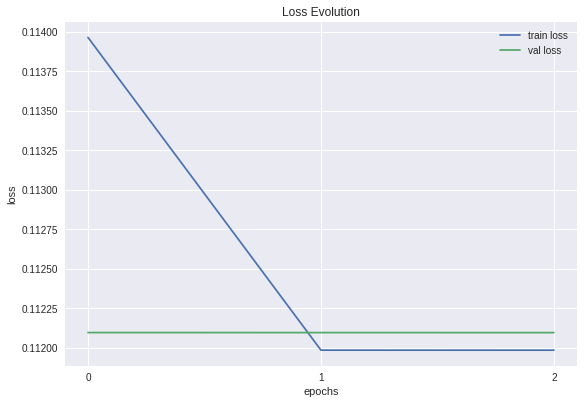

In [31]:
input_dim = 'dummy'
encoding_dim = 'dummy'
trn_datas = [X_train_conv, X_train_conv]
val_datas = [X_val_conv, X_val_conv]
logs6, ae6, enc6, dec6 = Launch(autoencoder_conv, 'mse', input_dim, encoding_dim, 
                                trn_datas, val_datas, 
                                debug=True)

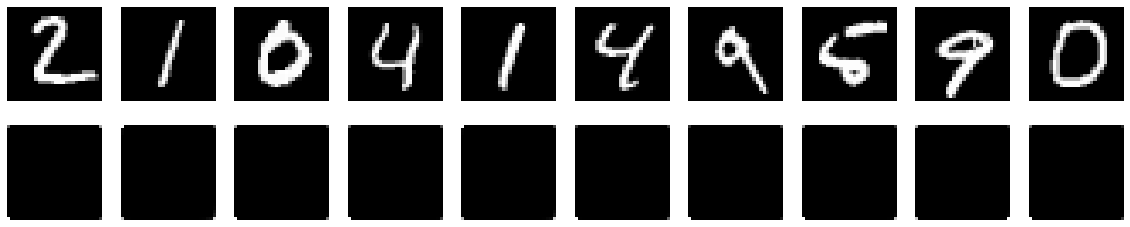

In [32]:
decd_imgs = ae6.predict(X_test_conv)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_conv[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decd_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Anti-Bruit

 13- Réalisez à l'aide d'une ou plusieurs architectures un AE anti-bruit (pour le bruit vous pouvez vous servir de 
 
 ```img_train = img_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img_train.shape)```

14- Testez sur des données non-bruitées

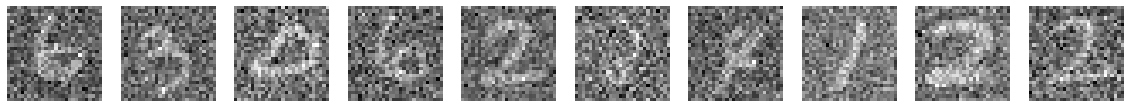

In [33]:
(X_train_clr, y_train_clr), (X_test_clr, y_test_clr) = mnist.load_data()

X_train_clr = X_train_clr.astype('float32') / 255.
X_test_clr = X_test_clr.astype('float32') / 255.
X_train_clr = np.reshape(X_train_clr, (len(X_train_clr), 28, 28, 1))
X_test_clr = np.reshape(X_test_clr, (len(X_test_clr), 28, 28, 1))

X_train_clr, X_val_clr, y_train_clr, y_val_clr = train_test_split(
    X_train_clr, y_train_clr, test_size=1/6, random_state=1)

noise_factor = 0.5
X_train_nsy = X_train_clr + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_clr.shape)
X_val_nsy = X_val_clr + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_val_clr.shape) 
X_test_nsy = X_test_clr + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_clr.shape)

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_train_nsy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

autoencoder :
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)

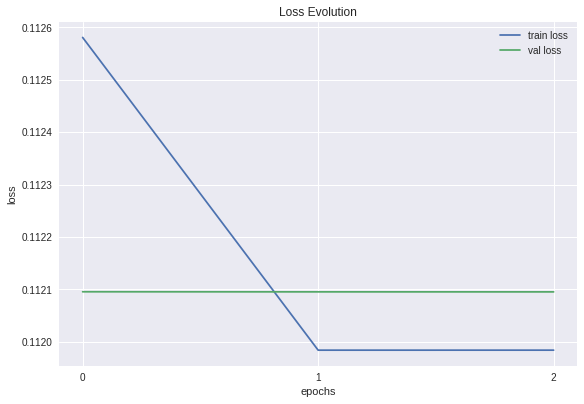

In [34]:
input_dim = 'dummy'
encoding_dim = 'dummy'
trn_datas = [X_train_nsy, X_train_clr]
val_datas = [X_val_nsy, X_val_clr]
logs7, ae7, encoder7, decoder7 = Launch(autoencoder_conv, 'mse', input_dim, encoding_dim, 
                                        trn_datas, val_datas,
                                        debug=True)

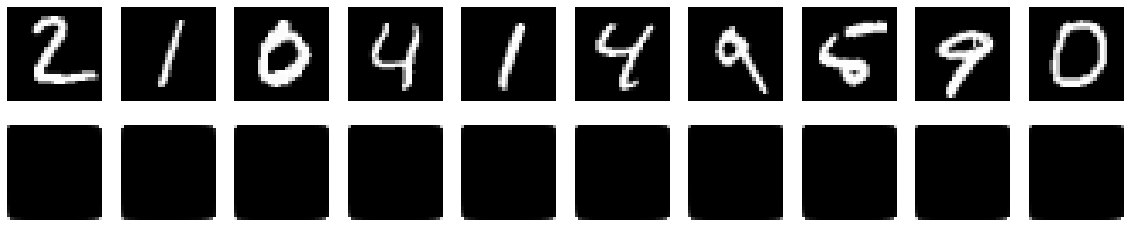

In [35]:
dcd = ae7.predict(X_test_nsy)
    
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_clr[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(dcd[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [36]:
def autoencoder_noise_red1(input_dim, encoding_dim):
    # This is our input image
    input_layer = keras.Input(shape=(28,28,1))
    
    #Encoder part
    encoded = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)

    #Decoder Part
    decoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(16, (3, 3), activation='relu')(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_layer, decoded)

    # This model maps an input to its encoded representation
    encoder = keras.Model(input_layer, encoded)
    
    # This is our encoded input
    encoded_input = keras.Input(shape=(4, 4, 8))
    
    # Retrieve the last layers of the autoencoder model
    decoder_layer = autoencoder.layers[-7](encoded_input)
    decoder_layer = autoencoder.layers[-6](decoder_layer)
    decoder_layer = autoencoder.layers[-5](decoder_layer)
    decoder_layer = autoencoder.layers[-4](decoder_layer)
    decoder_layer = autoencoder.layers[-3](decoder_layer)
    decoder_layer = autoencoder.layers[-2](decoder_layer)
    decoder_layer = autoencoder.layers[-1](decoder_layer)
    
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer)
    
    return autoencoder, encoder, decoder   

autoencoder :
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)

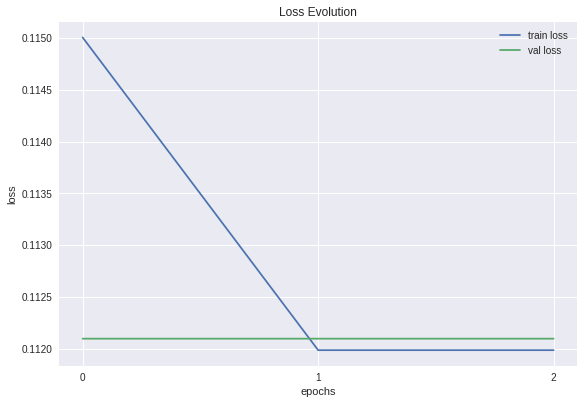

In [37]:
input_dim = 'dummy'
encoding_dim = 'dummy'
trn_datas = [X_train_nsy, X_train_clr]
val_datas = [X_val_nsy, X_val_clr]
logs8, ae8, encoder8, decoder8 = Launch(autoencoder_noise_red1, 'mse', input_dim, encoding_dim, 
                                        trn_datas, val_datas,
                                        debug=True)

In [38]:
def autoencoder_noise_red2(input_dim, encoding_dim):
    # This is our input image
    input_layer = keras.Input(shape=(28,28,1))
    
    #Encoder part
    encoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)

    #Decoder Part
    decoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_layer, decoded)

    # This model maps an input to its encoded representation
    encoder = keras.Model(input_layer, encoded)
    
    # This is our encoded input
    encoded_input = keras.Input(shape=(7, 7, 32))
    
    # Retrieve the last layers of the autoencoder model
    decoder_layer = autoencoder.layers[-5](encoded_input)
    decoder_layer = autoencoder.layers[-4](decoder_layer)
    decoder_layer = autoencoder.layers[-3](decoder_layer)
    decoder_layer = autoencoder.layers[-2](decoder_layer)
    decoder_layer = autoencoder.layers[-1](decoder_layer)
    
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer)
    
    return autoencoder, encoder, decoder   

autoencoder :
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 14, 14, 

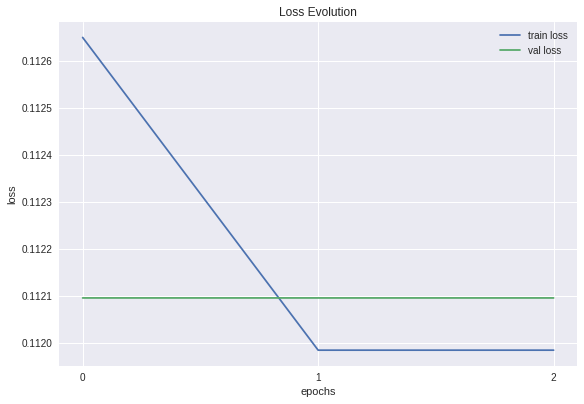

In [39]:
input_dim = 'dummy'
encoding_dim = 'dummy'
trn_datas = [X_train_nsy, X_train_clr]
val_datas = [X_val_nsy, X_val_clr]
logs9, ae9, encoder9, decoder9 = Launch(autoencoder_noise_red2, 'mse', input_dim, encoding_dim, 
                                        trn_datas, val_datas,
                                        debug=True)

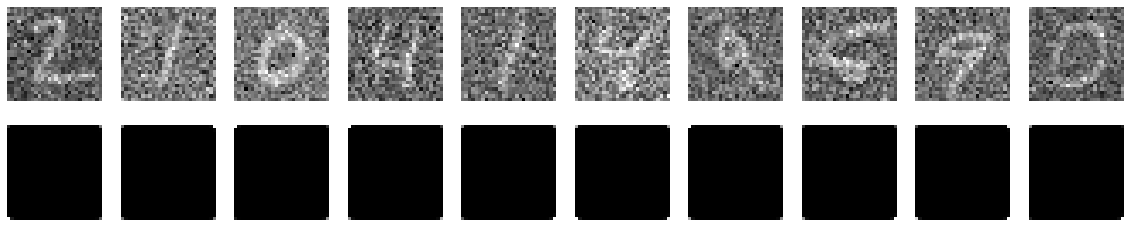

In [40]:
dcd = ae9.predict(X_test_nsy)
    
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_nsy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(dcd[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Etude comparative

 15- Faites une étude comparative de toutes les architectures avec des dimensions de code différentes. Discutez des résultats.
 
 16- Faites de la visualisation avec un AE. Comparez le résultat à TSNE et PCA/LDA.
 
 17- (Bonus) Utilisez un autre dataset de votre choix pour entrainer un AE performant. 

In [12]:
def mnist():
    from sklearn.preprocessing import StandardScaler
    df_mnist = pd.read_csv("./mnist_test.csv")
    return StandardScaler().fit_transform(df_mnist.drop(["label"],axis=1)),df_mnist["label"]

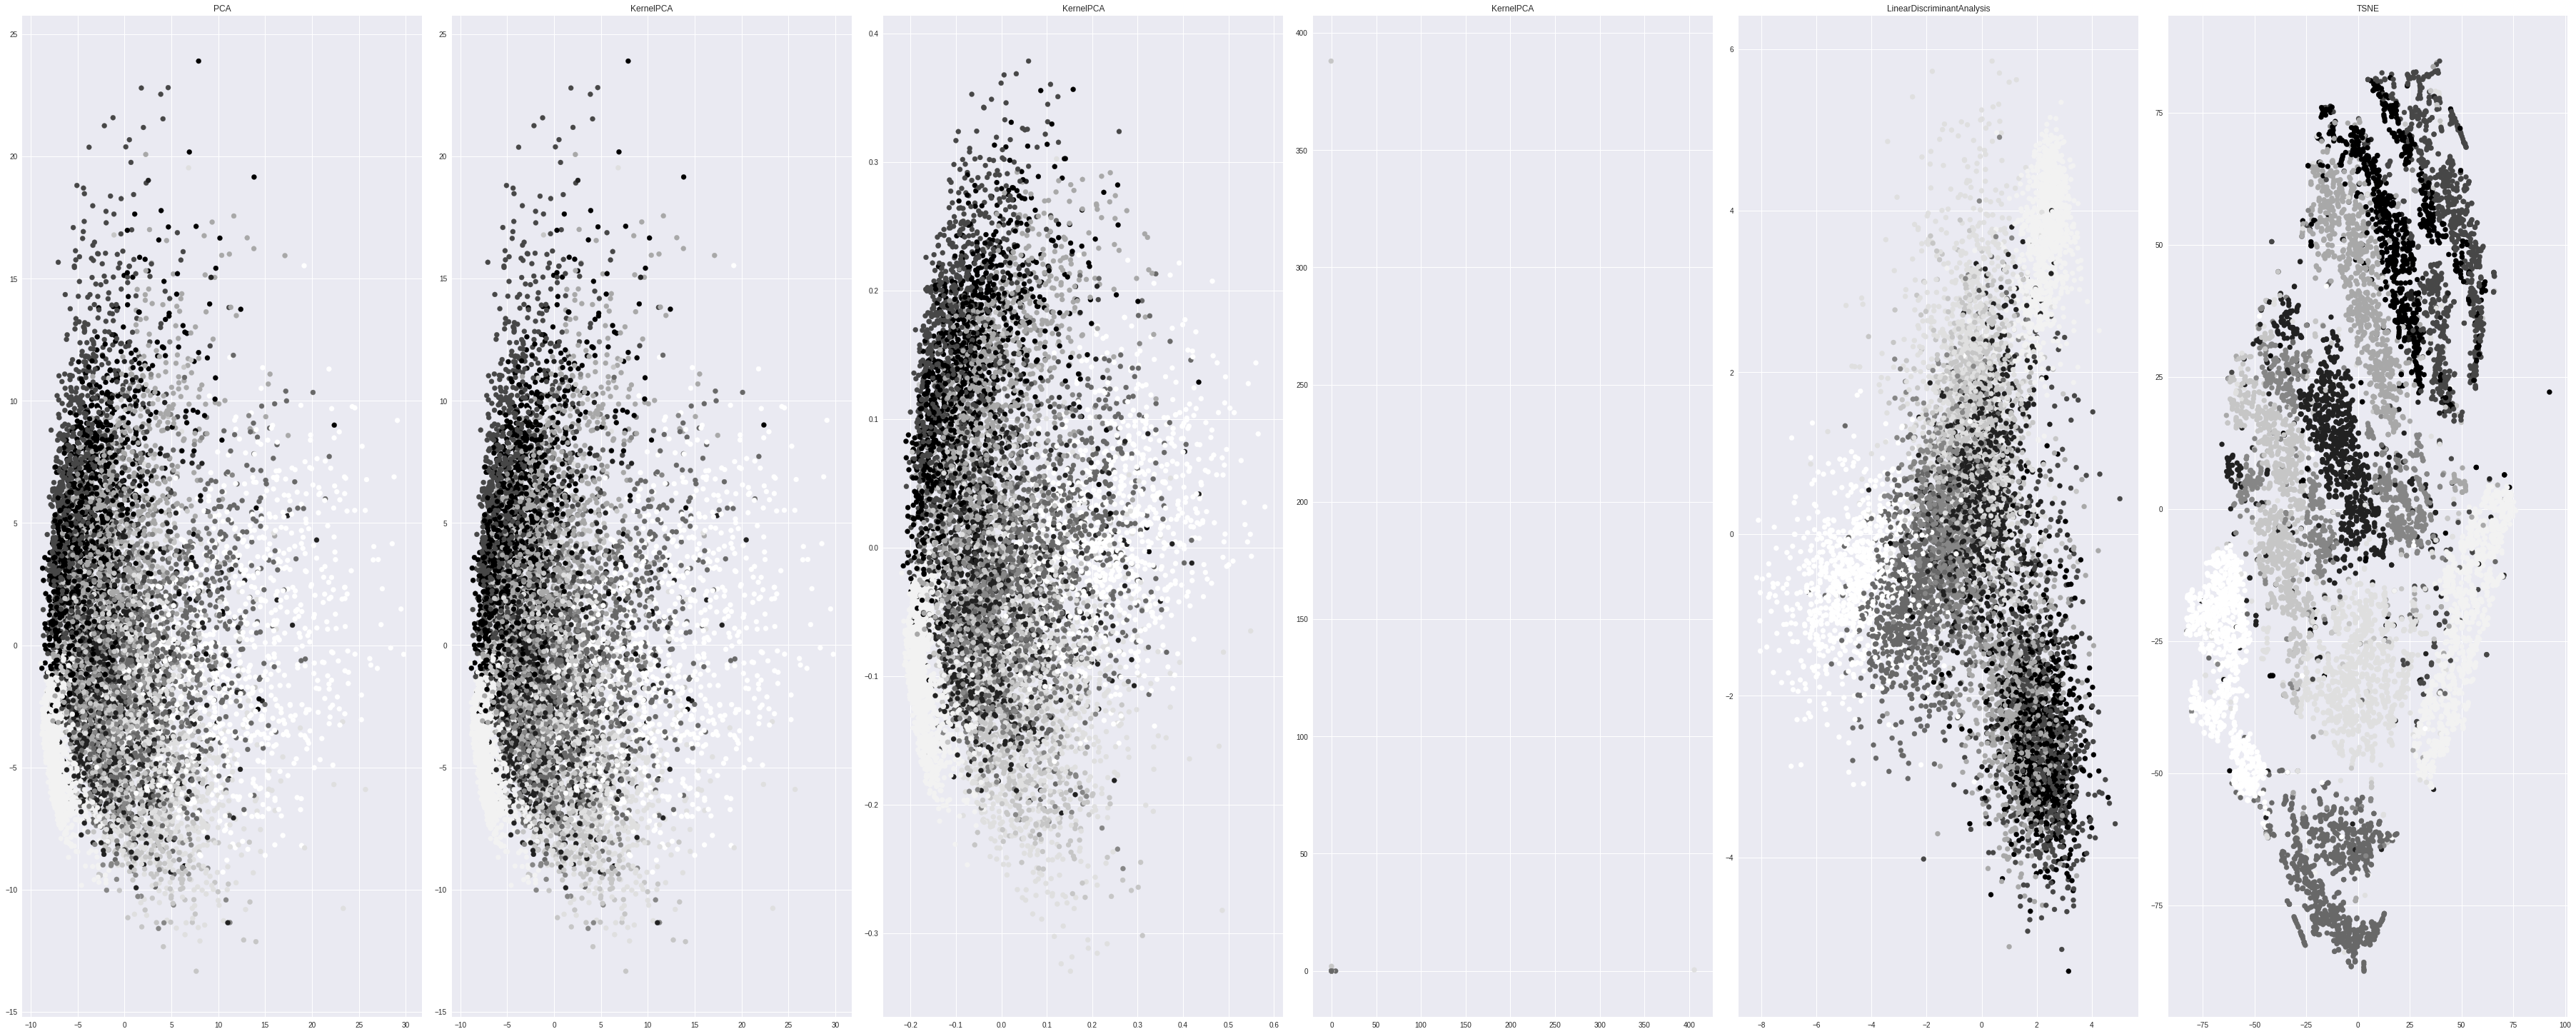

In [17]:
methodes = [
    PCA(n_components=2),
    
    KernelPCA(n_components=2, kernel='linear'),
    KernelPCA(n_components=2, kernel='sigmoid'),
    KernelPCA(n_components=2, kernel='poly'),
    
    LinearDiscriminantAnalysis(n_components=2),
    TSNE(n_components=2),
]

figsize = figsize = (50, 20)
rows = 1
cols = len(methodes)

axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)

X, y = mnist()
    
for i_c, mth in enumerate(methodes):
    trnsfrm = mth.fit_transform(X,y)
    axs[i_c].scatter(trnsfrm[:,0],trnsfrm[:,1],c=y)
        
for ax, col in zip(axs, methodes):
    ax.set_title(col.__class__.__name__)

In [16]:
print(X.shape)

(10000, 784)
